In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
colab_dir = '/content/drive/MyDrive/Colab Notebooks' 

In [3]:
!pip install nltk pythainlp scikit-learn==1.2.2 scikeras==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 77.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2


In [4]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Attention, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
tourism_reviews_en = pd.read_csv(f"{colab_dir}/eng_reviews_emotion_classify.csv")

In [9]:
tourism_reviews_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5909 entries, 0 to 5908
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0.1    5909 non-null   int64 
 1   Unnamed: 0      5909 non-null   int64 
 2   helpful_votes   5909 non-null   int64 
 3   location_id     5909 non-null   int64 
 4   lang            5909 non-null   object
 5   review_id       5909 non-null   int64 
 6   review          5909 non-null   object
 7   review_subject  5909 non-null   object
 8   trip_type       5892 non-null   object
 9   travel_date     5892 non-null   object
 10  rating          5909 non-null   int64 
 11  location_name   5909 non-null   object
 12  province        5909 non-null   object
 13  place_id        5909 non-null   object
 14  cleaned_review  5909 non-null   object
 15  emotion         5909 non-null   object
dtypes: int64(6), object(10)
memory usage: 738.8+ KB


In [7]:
tourism_reviews_en.head(5)

,Unnamed: 0.1,Unnamed: 0,helpful_votes,location_id,lang,review_id,review,review_subject,trip_type,travel_date,rating,location_name,province,place_id,cleaned_review,emotion
0,0,0,0,2209612,en,953596359,Besides elegant grand palace and wat pra kaew ...,"The place is nearby grand palace, in the area ...",Family,2024-05-31,5,Wat Ratchabophit,Bangkok,P03013220,besides elegant grand palace <OOV> wat pra kae...,joy
1,1,1,0,2209612,en,938998692,This is one of the last big king temples of Ba...,Nice Wat,Solo travel,2024-02-29,4,Wat Ratchabophit,Bangkok,P03013220,<OOV> <OOV> one <OOV> <OOV> last big king temp...,joy
2,2,2,6,2209612,en,933065689,"It is beautiful, clean and free to enter. Both...",Nice views,Solo travel,2023-12-31,4,Wat Ratchabophit,Bangkok,P03013220,<OOV> <OOV> beautiful clean <OOV> free <OOV> e...,joy
3,3,3,0,2209612,en,885904967,Wat Ratchabophit is a Buddhist temple located ...,Wat Ratchabophit - a temple characterized by u...,Couples,2022-10-31,5,Wat Ratchabophit,Bangkok,P03013220,wat ratchabophit <OOV> <OOV> buddhist temple l...,joy
4,4,4,4,2209612,en,782967555,Wat Ratchabophit is a historic royal temple bu...,"Beautiful, peaceful",NONE,2021-01-31,5,Wat Ratchabophit,Bangkok,P03013220,wat ratchabophit <OOV> <OOV> historic royal te...,joy


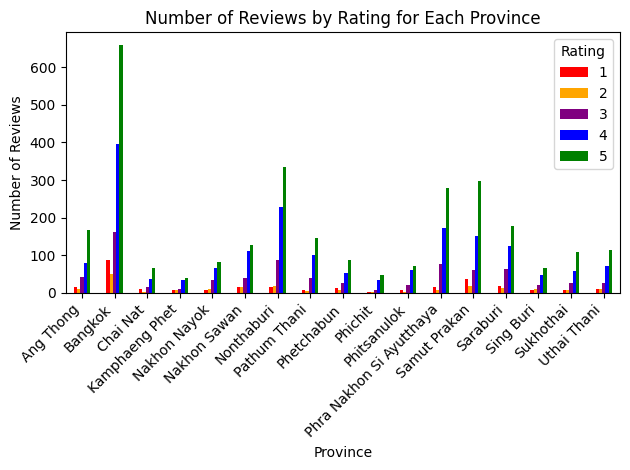

In [10]:
rating_counts = tourism_reviews_en.groupby(['province', 'rating']).size().unstack(fill_value=0)

# Define colors for each rating
colors = {5: 'green', 4: 'blue', 3: 'purple', 2: 'orange', 1: 'red'}

# Plot the data
rating_counts.plot(kind='bar', stacked=False, color=[colors[rating] for rating in sorted(rating_counts.columns)])

# Set plot title and labels
plt.title('Number of Reviews by Rating for Each Province')
plt.xlabel('Province')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45, ha="right")

# Add legend
plt.legend(title='Rating')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation and numbers
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Apply cleaning function to the 'review' column
tourism_reviews_en['cleaned_review'] = tourism_reviews_en['review'].apply(clean_text)


In [11]:
import requests
import zipfile
import os

# URL for GloVe embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip = "glove.6B.zip"

# Download the GloVe embeddings
print("Downloading GloVe embeddings...")
response = requests.get(glove_url)
with open(glove_zip, 'wb') as f:
    f.write(response.content)
print("Download complete.")

# Unzip the GloVe embeddings
with zipfile.ZipFile(glove_zip, 'r') as zip_ref:
    zip_ref.extractall(".")
print("Extraction complete.")


KeyboardInterrupt: 

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Assuming you've extracted GloVe embeddings in the current directory
glove_file = "glove.6B.300d.txt"  # Use the 300-dimensional GloVe vectors
embeddings_index = load_glove_embeddings(glove_file)

In [14]:
# Define OOV vector
embedding_dim = 300
oov_vector = np.random.normal(size=(embedding_dim,))

In [15]:
# Tokenization
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(tourism_reviews_en['cleaned_review'])
word_index = tokenizer.word_index

In [48]:
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = oov_vector

NameError: name 'embeddings_index' is not defined

In [16]:
# Convert reviews to sequences
X = tokenizer.texts_to_sequences(tourism_reviews_en['cleaned_review'])

# Padding sequences to ensure uniform input size
max_len = 100
X = pad_sequences(X, maxlen=max_len)

In [17]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(tourism_reviews_en['location_id'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Parameters
vocab_size = len(word_index) + 1  # จำนวนคำใน vocabulary รวมทั้ง <OOV>
embedding_dim = 100
lstm_units = 128

In [20]:
# Create LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
    Bidirectional(LSTM(lstm_units, return_sequences=True)),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')  # Output layer with softmax activation
])
# lstm_model = tf.keras.Sequential([
#     tf.keras.layers.Embedding(vocab_size, embedding_dim),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)),
#     tf.keras.layers.Dense(32, activation='relu', kernel_regularizer = tf.keras.regularizers.l2(0.1)),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
from tensorflow.keras.utils import to_categorical

# ปรับ Hyperparameters
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)  # ปรับ learning rate

# Convert y_train and y_test to one-hot encoded labels
y_train_categorical = to_categorical(y_train, num_classes=len(label_encoder.classes_))
y_test_categorical = to_categorical(y_test, num_classes=len(label_encoder.classes_))

# Compile model with categorical_crossentropy
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [55]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [62]:
history = lstm_model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical), callbacks=[early_stopping])


Epoch 1/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 85s 528ms/step - accuracy: 5.7794e-05 - loss: 7.2643 - val_accuracy: 8.4602e-04 - val_loss: 7.2742
Epoch 2/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 83s 535ms/step - accuracy: 0.0021 - loss: 7.2431 - val_accuracy: 0.0000e+00 - val_loss: 7.2912
Epoch 3/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 77s 521ms/step - accuracy: 0.0031 - loss: 7.1745 - val_accuracy: 0.0000e+00 - val_loss: 7.3474
Epoch 4/20
148/148 ━━━━━━━━━━━━━━━━━━━━ 82s 517ms/step - accuracy: 0.0026 - loss: 7.0195 - val_accuracy: 0.0000e+00 - val_loss: 7.4678


In [12]:
from tensorflow.keras.models import load_model
# Save the trained model
# lstm_model.save(f'{colab_dir}/lstm_model_sample.h5')
lstm_model = load_model(f'{colab_dir}/lstm_model_sample.h5')


In [25]:
def recommend_place(review_text):
    # Preprocess the input review
    sequence = tokenizer.texts_to_sequences([review_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_len)

    # Predict the place ID
    predicted_class = lstm_model.predict(padded_sequence)
    predicted_label = np.argmax(predicted_class, axis=-1)

    # Convert the predicted label back to place ID or name
    recommended_place = label_encoder.inverse_transform(predicted_label)

    return recommended_place[0]

# Example usage
sample_review = "water market"
recommended_place = recommend_place(sample_review)
print(f"Recommended place: {recommended_place}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
Recommended place: 8685967


In [26]:
tourism_reviews_en[tourism_reviews_en['location_id'] == recommended_place]

,Unnamed: 0.1,Unnamed: 0,helpful_votes,location_id,lang,review_id,review,review_subject,trip_type,travel_date,rating,location_name,province,place_id,cleaned_review,emotion
1171,1171,1171,0,8685967,en,642580486,Wat Okat or Opportunity Temple is believed to ...,The place to be worshiped by job seekers,Couples,2018-12-31,4,Wat Okat Si Bua Ban,Pathum Thani,P03013520,wat okat <OOV> opportunity temple <OOV> believ...,joy
1172,1172,1172,2,8685967,en,342031046,I had never been to this particular Wat (Templ...,See ancient statues of Buddha housed here.,Solo travel,2015-12-31,5,Wat Okat Si Bua Ban,Pathum Thani,P03013520,<OOV> <OOV> never <OOV> <OOV> <OOV> particular...,joy


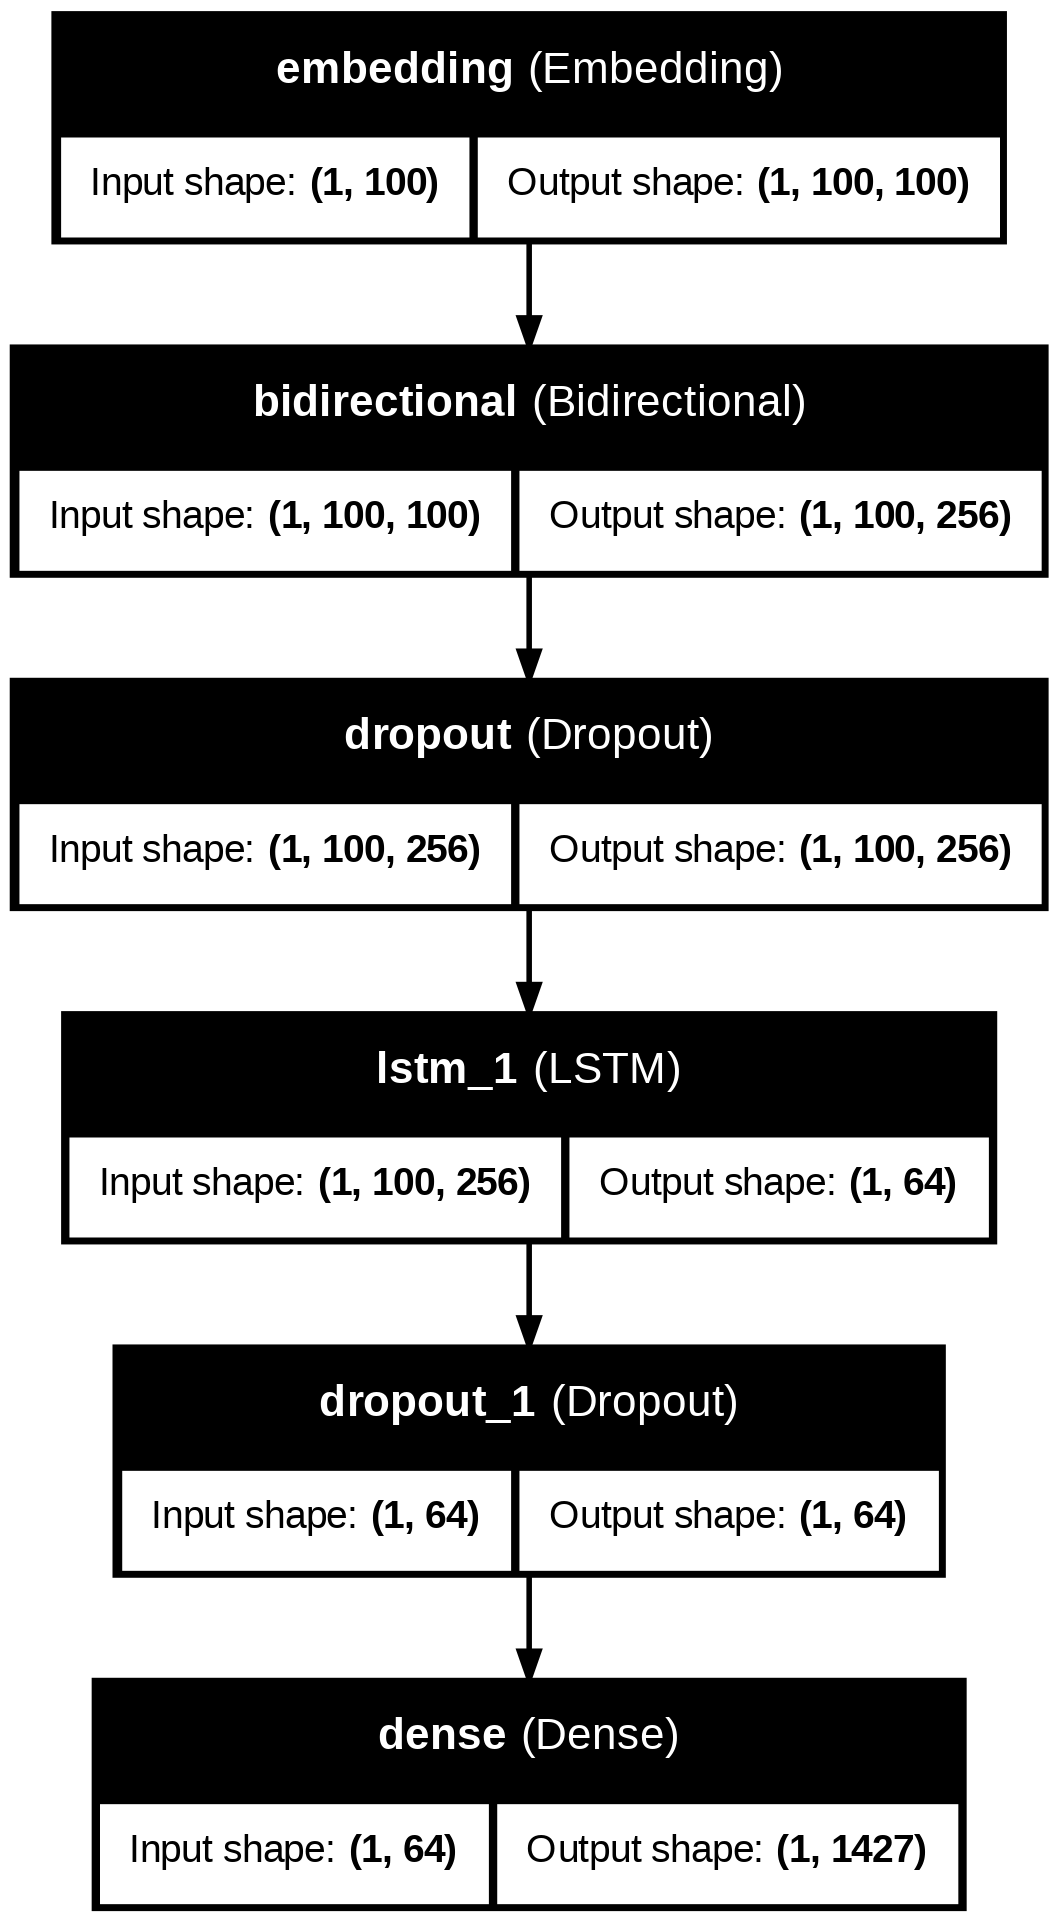

In [27]:
# Visualize the model architecture
plot_model(lstm_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [28]:
# Display model summary
lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 100, 100)               │       1,740,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (1, 100, 256)               │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (1, 100, 256)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (1, 64)                     │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (1, 64)                     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 1427)                   │          92,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,149,727 (8.20 MB)

 Trainable params: 2,149,727 (8.20 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

lstm_pred = np.argmax(lstm_model.predict(X_test), axis=-1)
accuracy = accuracy_score(y_test, lstm_pred)
print("Accuracy:", accuracy)

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step
Accuracy: 0.0


In [ ]:


conf_matrix = confusion_matrix(y_test, lstm_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
print(classification_report(y_test, lstm_pred, target_names='emotion'))


In [31]:
from tensorflow.keras.metrics import top_k_categorical_accuracy

def top_k_accuracy(y_true, y_pred, k=5):
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

# Example usage with Top-5 accuracy
lstm_pred_prob = lstm_model.predict(X_test)
top_5_accuracy = top_k_accuracy(y_test, lstm_pred_prob, k=5)
print("Top-5 Accuracy:", np.mean(top_5_accuracy))


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step


InvalidArgumentError: {{function_node __wrapped__InTopKV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} targets must be 1-dimensional [Op:InTopKV2] name: 

In [32]:
# ROC Curve and AUC

fpr, tpr, thresholds = roc_curve(y_test, lstm_pred_prob[:, 1])
auc = roc_auc_score(y_test, lstm_pred_prob[:, 1])

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

ValueError: multiclass format is not supported

In [33]:
def mean_reciprocal_rank(y_true, y_pred):
    ranks = []
    for true, pred in zip(y_true, y_pred):
        rank = np.where(np.argsort(pred)[::-1] == true)[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)

mrr = mean_reciprocal_rank(y_test, lstm_pred_prob)
print("Mean Reciprocal Rank (MRR):", mrr)


Mean Reciprocal Rank (MRR): 0.0045175638527143284


In [34]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x600 with 0 Axes>